In [1]:
import pandas as pd

file_path = 'data/combined_seismic_data.pkl'
data = pd.read_pickle(file_path)

data_info = data.info()
data_head = data.head()

data_info, data_head

missing_data = data.isnull().sum()

missing_percentage = (missing_data / len(data)) * 100

missing_data_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Count', ascending=False)

missing_data_summary

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 683569 entries, 2011-01-01 00:00:00 to 2023-12-31 00:00:00
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   EBCN    222551 non-null  float64
 1   ECBD    579579 non-null  float64
 2   ECNE    555629 non-null  float64
 3   ECPN    518336 non-null  float64
 4   ECZM    564552 non-null  float64
 5   EMCN    529983 non-null  float64
 6   EMFO    537017 non-null  float64
 7   EMFS    593136 non-null  float64
 8   EMNR    512984 non-null  float64
 9   EMSG    514380 non-null  float64
 10  EPDN    464042 non-null  float64
 11  EPIT    505031 non-null  float64
 12  EPLC    481845 non-null  float64
 13  ESLN    566058 non-null  float64
 14  ESPC    572403 non-null  float64
 15  ESVO    557203 non-null  float64
dtypes: float64(16)
memory usage: 88.7 MB


,Missing Count,Missing Percentage
EBCN,461018,67.442789
EPDN,219527,32.114827
EPLC,201724,29.510408
EPIT,178538,26.118504
EMNR,170585,24.955052
EMSG,169189,24.750830
ECPN,165233,24.172103
EMCN,153586,22.468251
EMFO,146552,21.439240
ECNE,127940,18.716472


In [2]:
def interpolate_small_gaps(column):
    missing = column.isnull().astype(int)
    
    groups = missing.groupby(missing.ne(missing.shift()).cumsum()).cumsum()
    
    small_gaps = groups[groups <= 6].index
    column.loc[small_gaps] = column.loc[small_gaps].interpolate(method='linear')
    return column

data_interpolated = data.apply(interpolate_small_gaps, axis=0)

data_interpolated.to_pickle('data/interpolated_seismic_data.pkl')

data_interpolated.head()

,EBCN,ECBD,ECNE,ECPN,ECZM,EMCN,EMFO,EMFS,EMNR,EMSG,EPDN,EPIT,EPLC,ESLN,ESPC,ESVO
Time,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,3.494819,0.612916,4.328451,3.277108,0.591486,1.298117,NaN,1.340139,1.259969,0.667297,NaN,NaN,3.046057,0.753591,0.674584,1.301672
2011-01-01 00:10:00,3.332035,0.541441,4.237293,3.179923,0.538378,1.123753,NaN,1.193932,1.112514,0.612028,NaN,NaN,2.925008,0.687502,0.588634,1.159698
2011-01-01 00:20:00,3.474162,0.566139,4.601026,3.455442,0.541607,1.167423,NaN,1.328691,1.094077,0.579256,NaN,NaN,3.024596,0.654296,0.634195,1.139924
2011-01-01 00:30:00,3.251357,0.521349,4.036127,3.073853,0.526033,1.061147,NaN,1.204915,1.030863,0.551227,NaN,NaN,2.619229,0.617176,0.607511,1.077872
2011-01-01 00:40:00,3.827404,0.580080,4.312200,3.310499,0.576615,1.147253,NaN,1.233082,1.161106,0.614329,NaN,NaN,2.939530,0.691127,0.611761,1.154763


In [3]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
import joblib

file_path = 'data/interpolated_seismic_data.pkl'
df = joblib.load(file_path)

def evaluate_imputation(imputer, df, name):
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    mse = mean_squared_error(df.fillna(df.mean()), df_imputed)  
    file_path = f'data/{name}_imputed_dataset.pkl'
    df_imputed.to_pickle(file_path)
    return df_imputed, mse, file_path

imputers = {
    "IterativeImputer_min0": IterativeImputer(max_iter=10, random_state=0, min_value=0),
    "SimpleImputer_mean": SimpleImputer(strategy='mean'),
    "SimpleImputer_median": SimpleImputer(strategy='median'),
    "SimpleImputer_most_frequent": SimpleImputer(strategy='most_frequent'),
    "SimpleImputer_constant": SimpleImputer(strategy='constant', fill_value=0),
}

results = {}
for name, imputer in imputers.items():
    df_imputed, mse, file_path = evaluate_imputation(imputer, df, name)
    results[name] = (df_imputed, mse, file_path)
    print(f'{name} MSE: {mse} - File saved at: {file_path}')

best_imputation = min(results.items(), key=lambda x: x[1][1])
best_imputed_df, best_mse, best_file_path = best_imputation[1]
best_name = best_imputation[0]
print(f'Best Imputation Method: {best_name} with MSE: {best_mse} - File saved at: {best_file_path}')

results



C:\Users\giuli\Desktop\Aquarium\tf_aquarium\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer_min0 MSE: 7.378335804800363 - File saved at: data/IterativeImputer_min0_imputed_dataset.pkl
SimpleImputer_mean MSE: 0.0 - File saved at: data/SimpleImputer_mean_imputed_dataset.pkl
SimpleImputer_median MSE: 0.13117415657592027 - File saved at: data/SimpleImputer_median_imputed_dataset.pkl
SimpleImputer_most_frequent MSE: 2.081227286846233 - File saved at: data/SimpleImputer_most_frequent_imputed_dataset.pkl
SimpleImputer_constant MSE: 2.081227286846233 - File saved at: data/SimpleImputer_constant_imputed_dataset.pkl
Best Imputation Method: SimpleImputer_mean with MSE: 0.0 - File saved at: data/SimpleImputer_mean_imputed_dataset.pkl


{'IterativeImputer_min0': (                         EBCN      ECBD      ECNE      ECPN      ECZM  \
  Time                                                                    
  2011-01-01 00:00:00  3.494819  0.612916  4.328451  3.277108  0.591486   
  2011-01-01 00:10:00  3.332035  0.541441  4.237293  3.179923  0.538378   
  2011-01-01 00:20:00  3.474162  0.566139  4.601026  3.455442  0.541607   
  2011-01-01 00:30:00  3.251357  0.521349  4.036127  3.073853  0.526033   
  2011-01-01 00:40:00  3.827404  0.580080  4.312200  3.310499  0.576615   
  ...                       ...       ...       ...       ...       ...   
  2023-12-30 23:20:00  5.140788  0.841244  5.121965  7.010836  0.946323   
  2023-12-30 23:30:00  5.201291  0.791314  5.140913  7.829842  0.947630   
  2023-12-30 23:40:00  5.504544  0.875486  5.627425  8.219273  1.074115   
  2023-12-30 23:50:00  5.504544  0.875486  5.627425  8.219273  1.074115   
  2023-12-31 00:00:00  5.504544  0.875486  5.627425  8.219273  1.074115   


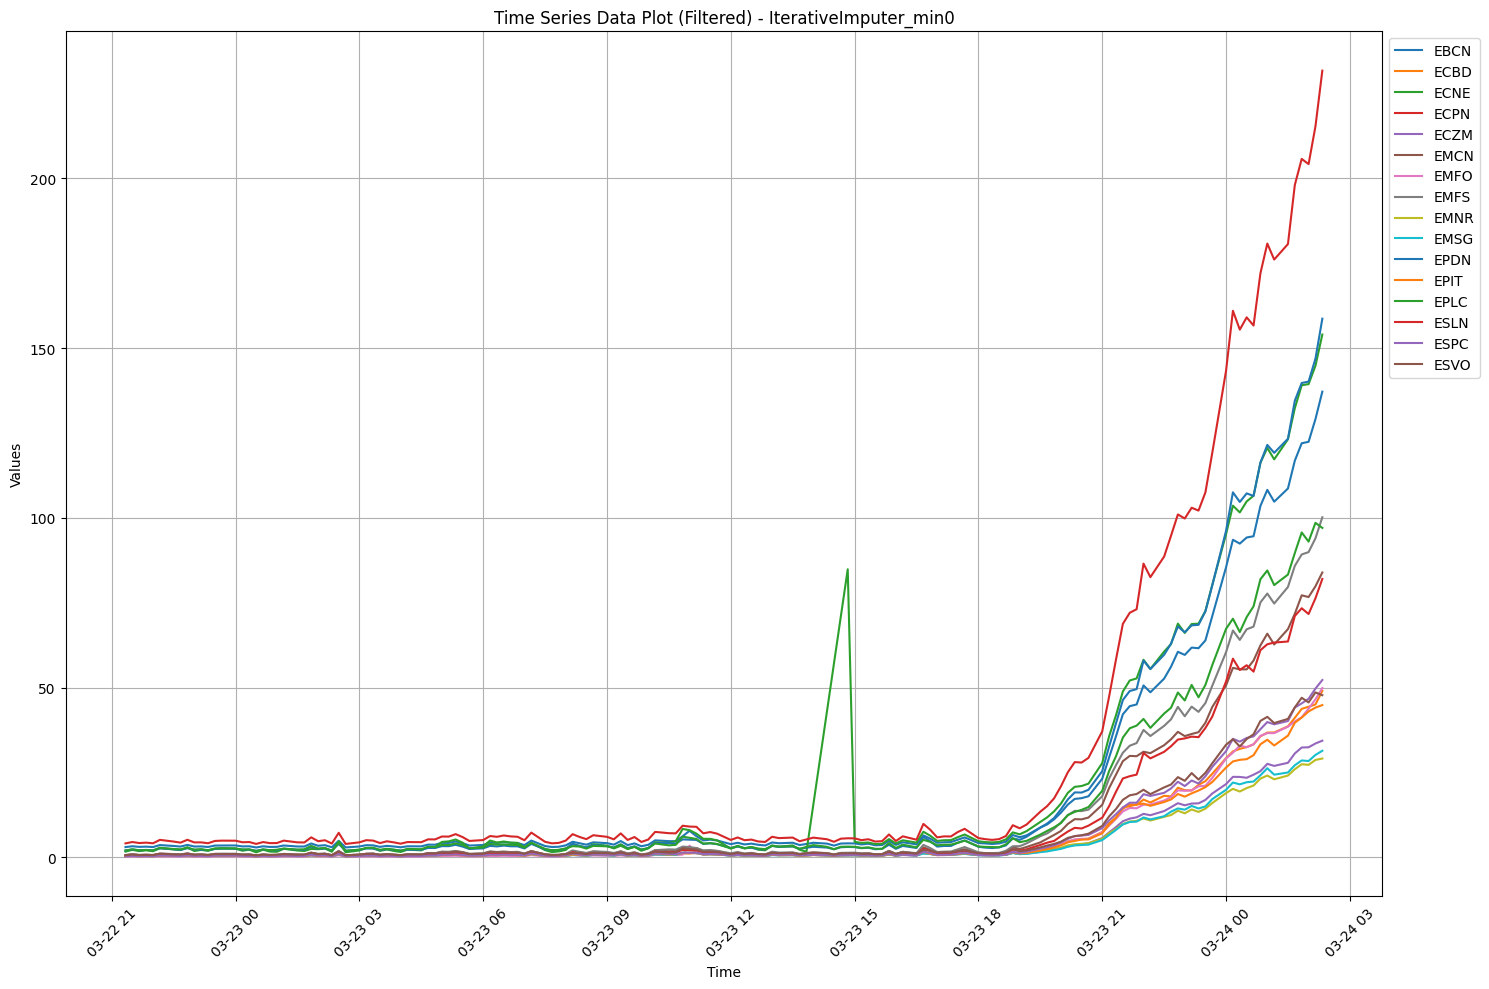

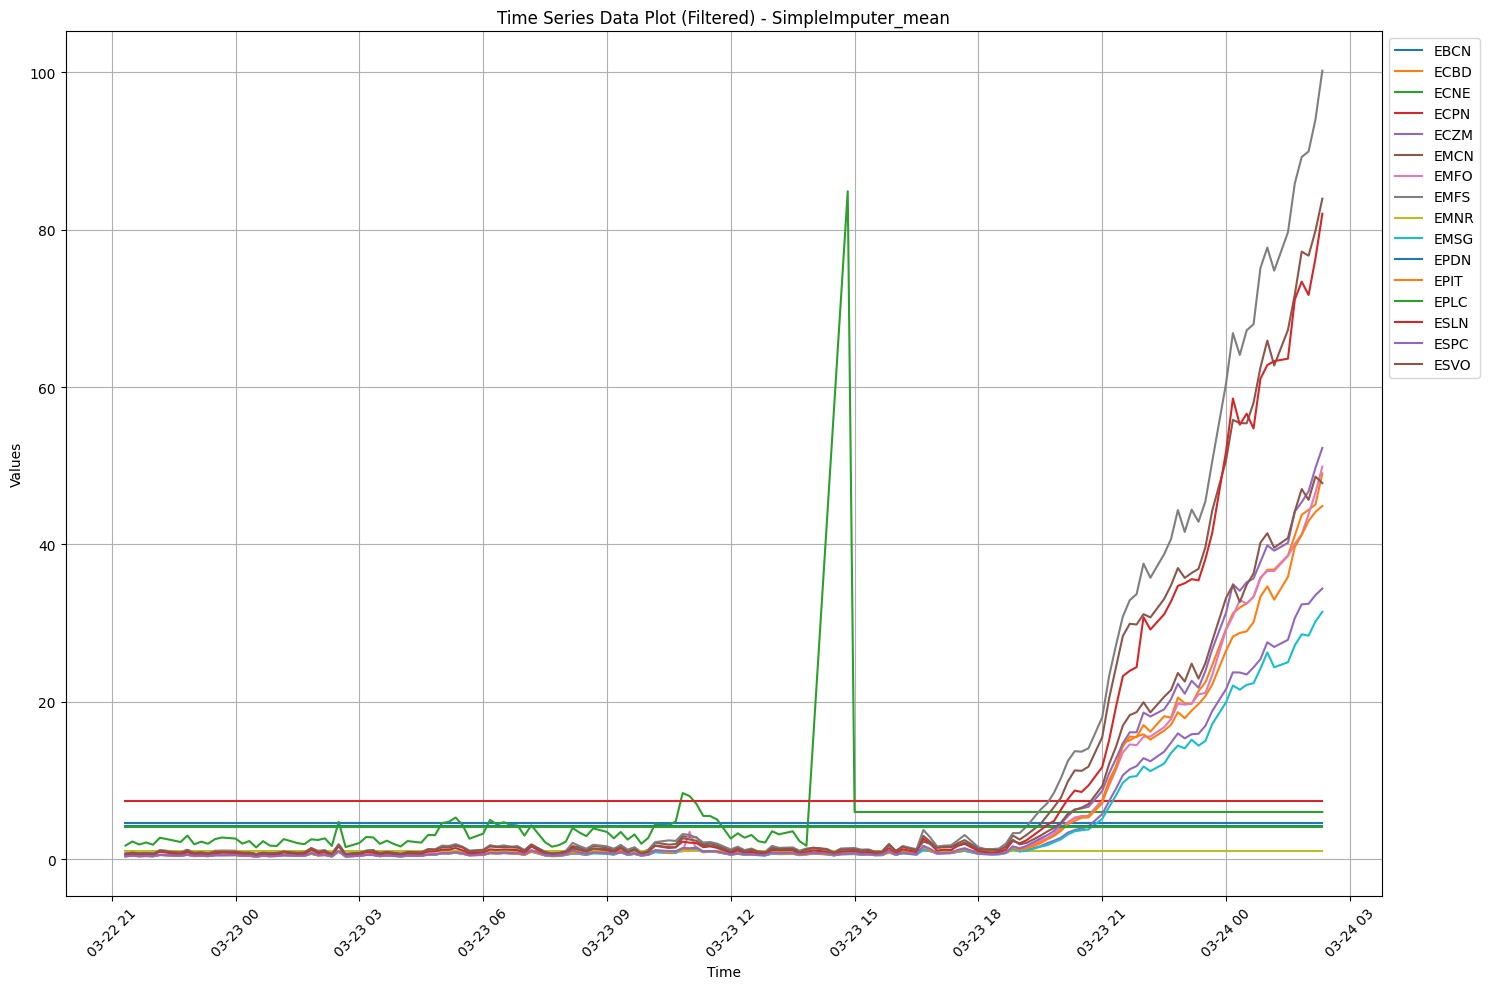

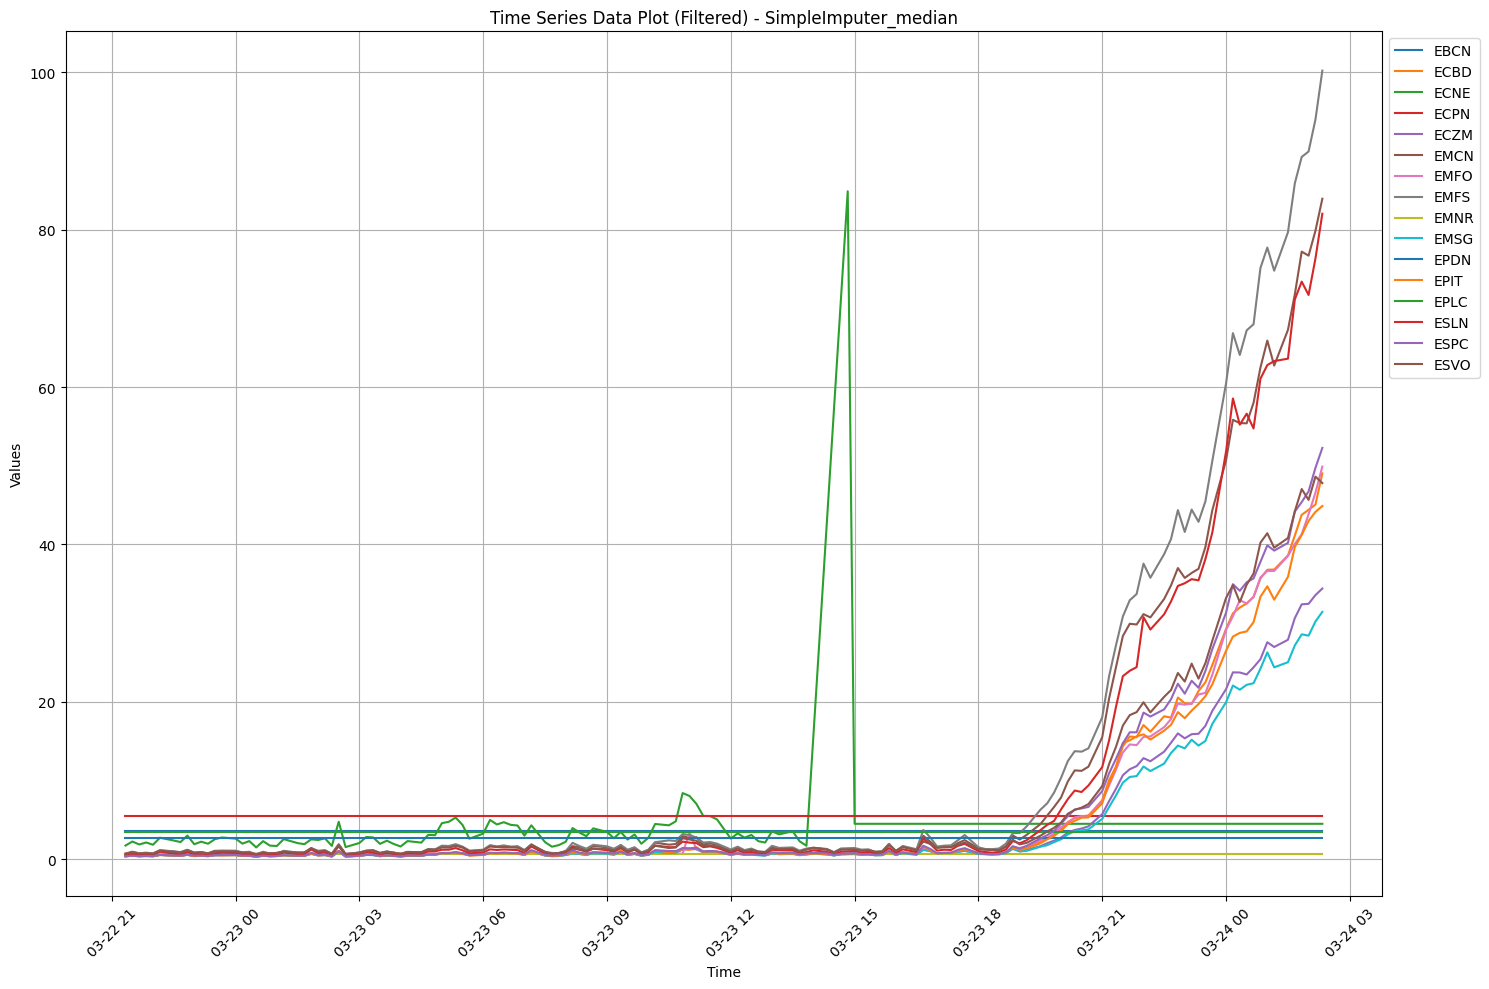

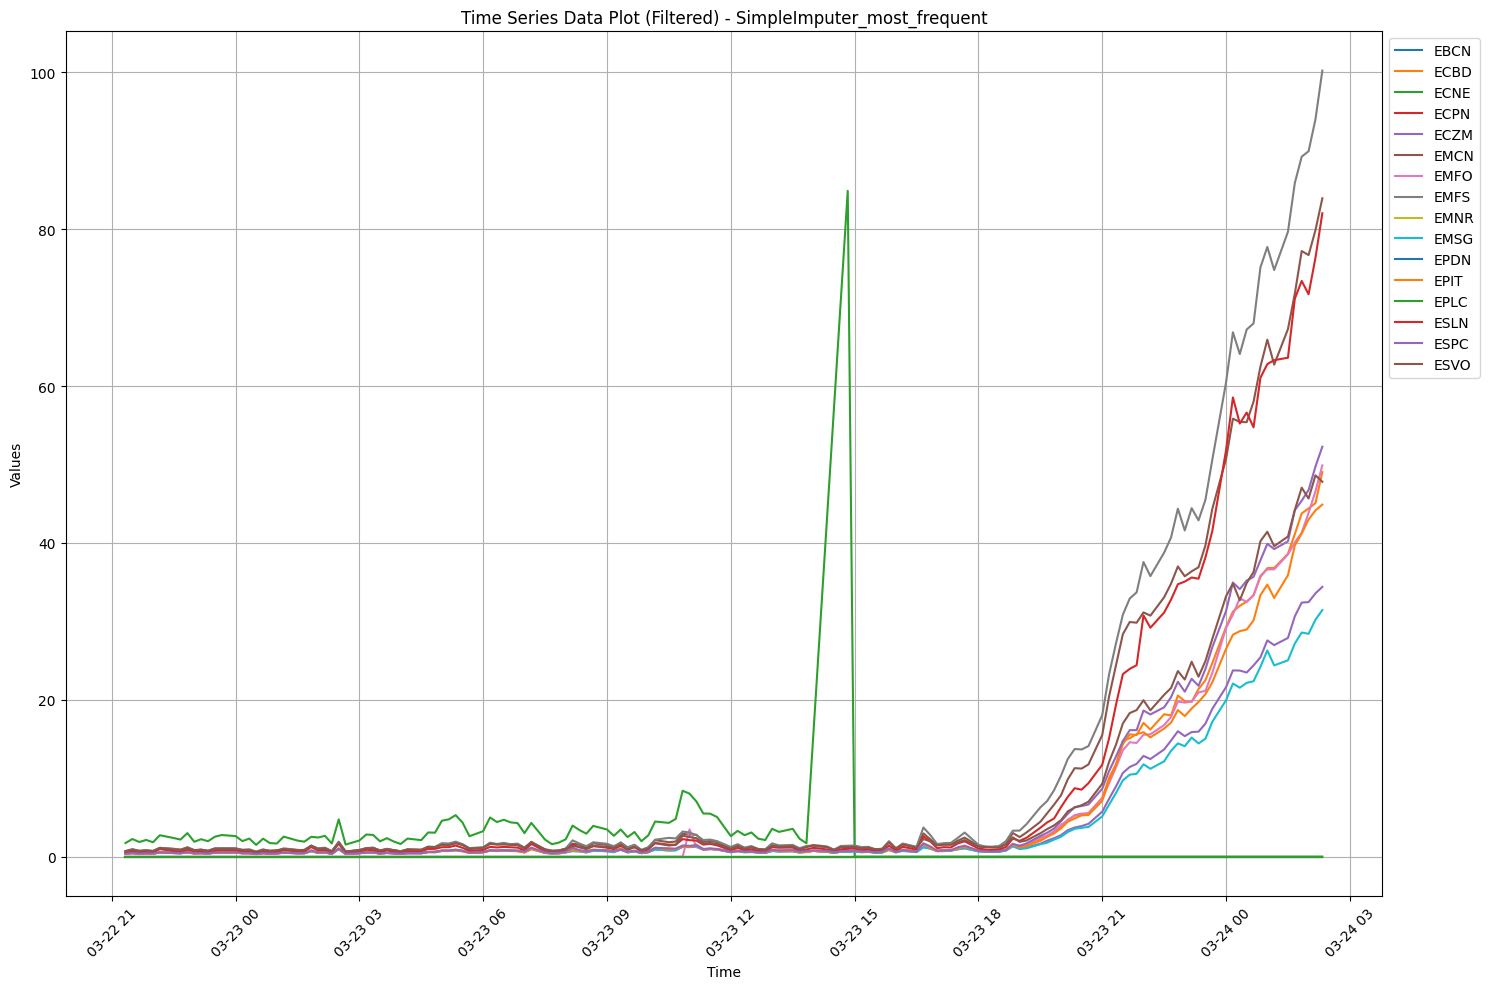

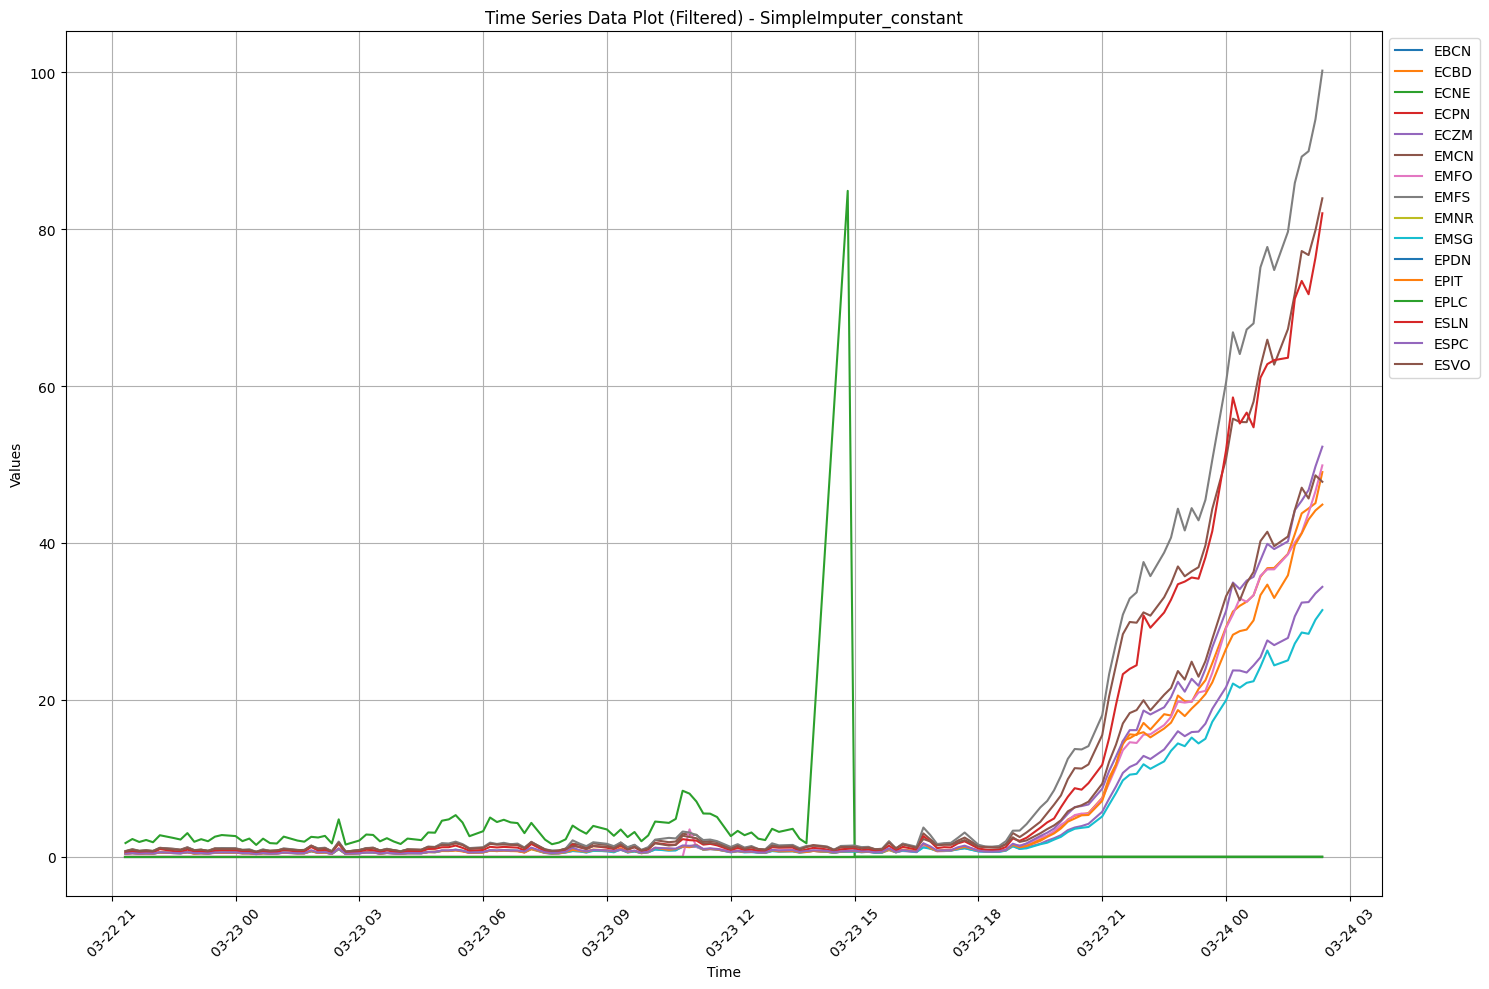

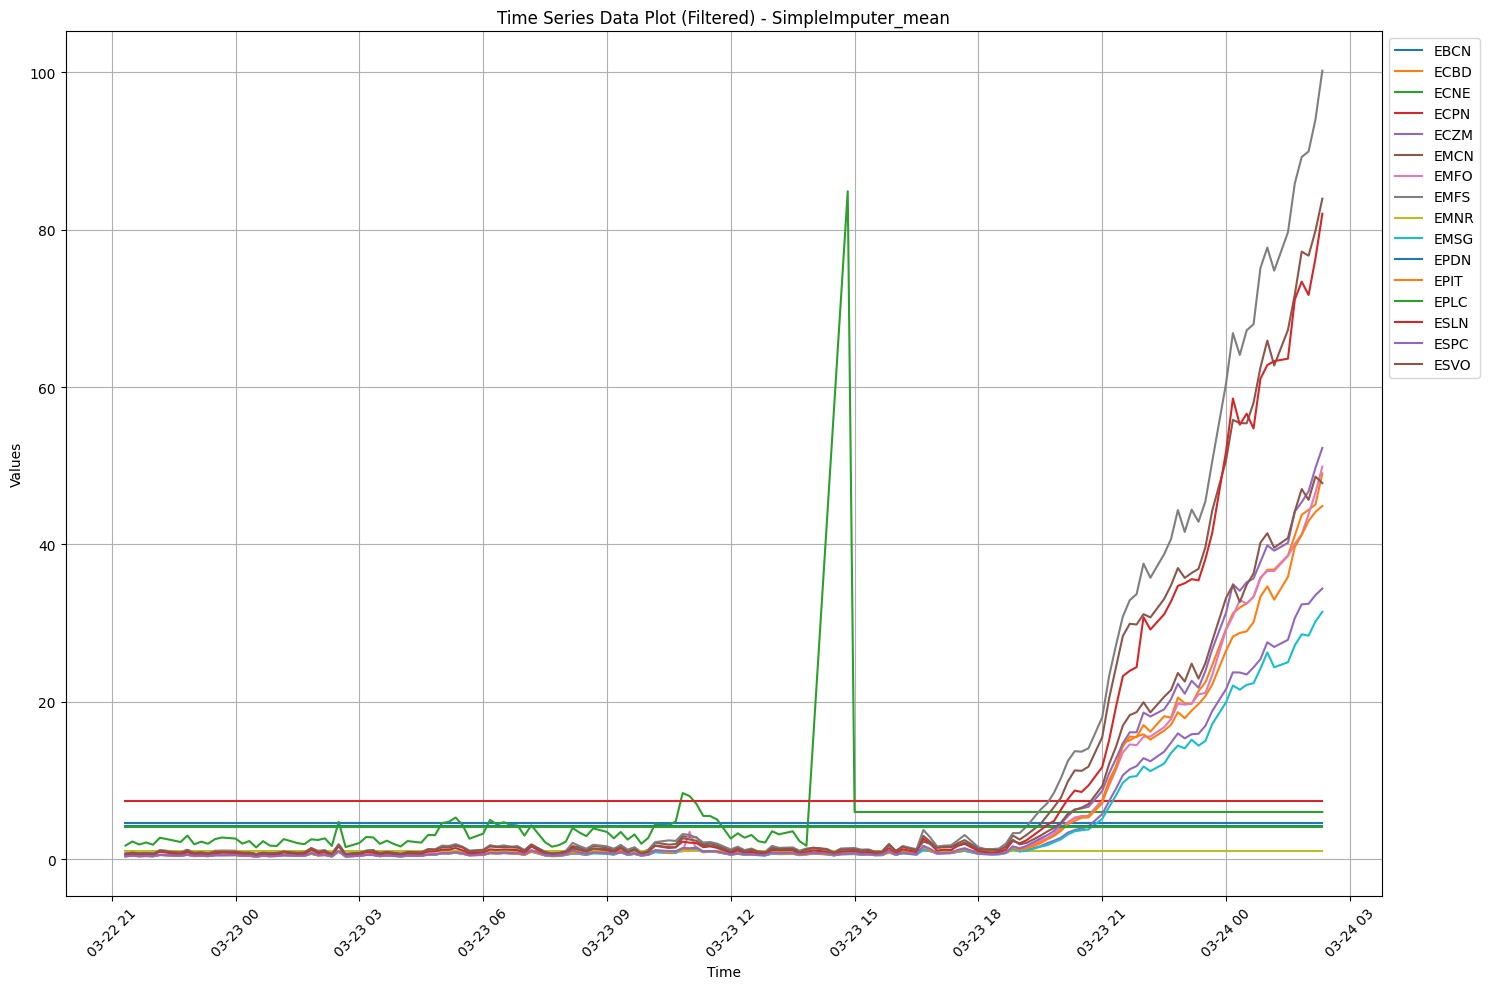

In [4]:
import matplotlib.pyplot as plt

file_paths = [
    'data/IterativeImputer_min0_imputed_dataset.pkl',
    'data/SimpleImputer_mean_imputed_dataset.pkl',
    'data/SimpleImputer_median_imputed_dataset.pkl',
    'data/SimpleImputer_most_frequent_imputed_dataset.pkl',
    'data/SimpleImputer_constant_imputed_dataset.pkl',
    'data/SimpleImputer_mean_imputed_dataset.pkl'
]

start_time = '2021-3-22 21:20:00'
end_time = '2021-3-24 2:20:00'

def create_and_show_plot(df, file_name, start_time, end_time):
    filtered_df = df.loc[start_time:end_time]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    for column in filtered_df.columns:
        ax.plot(filtered_df.index, filtered_df[column], label=column)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Time Series Data Plot (Filtered) - {file_name}')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for file_path in file_paths:
    df = pd.read_pickle(file_path)
    file_name = file_path.split('/')[-1].replace('_imputed_dataset.pkl', '')
    create_and_show_plot(df, file_name, start_time, end_time)

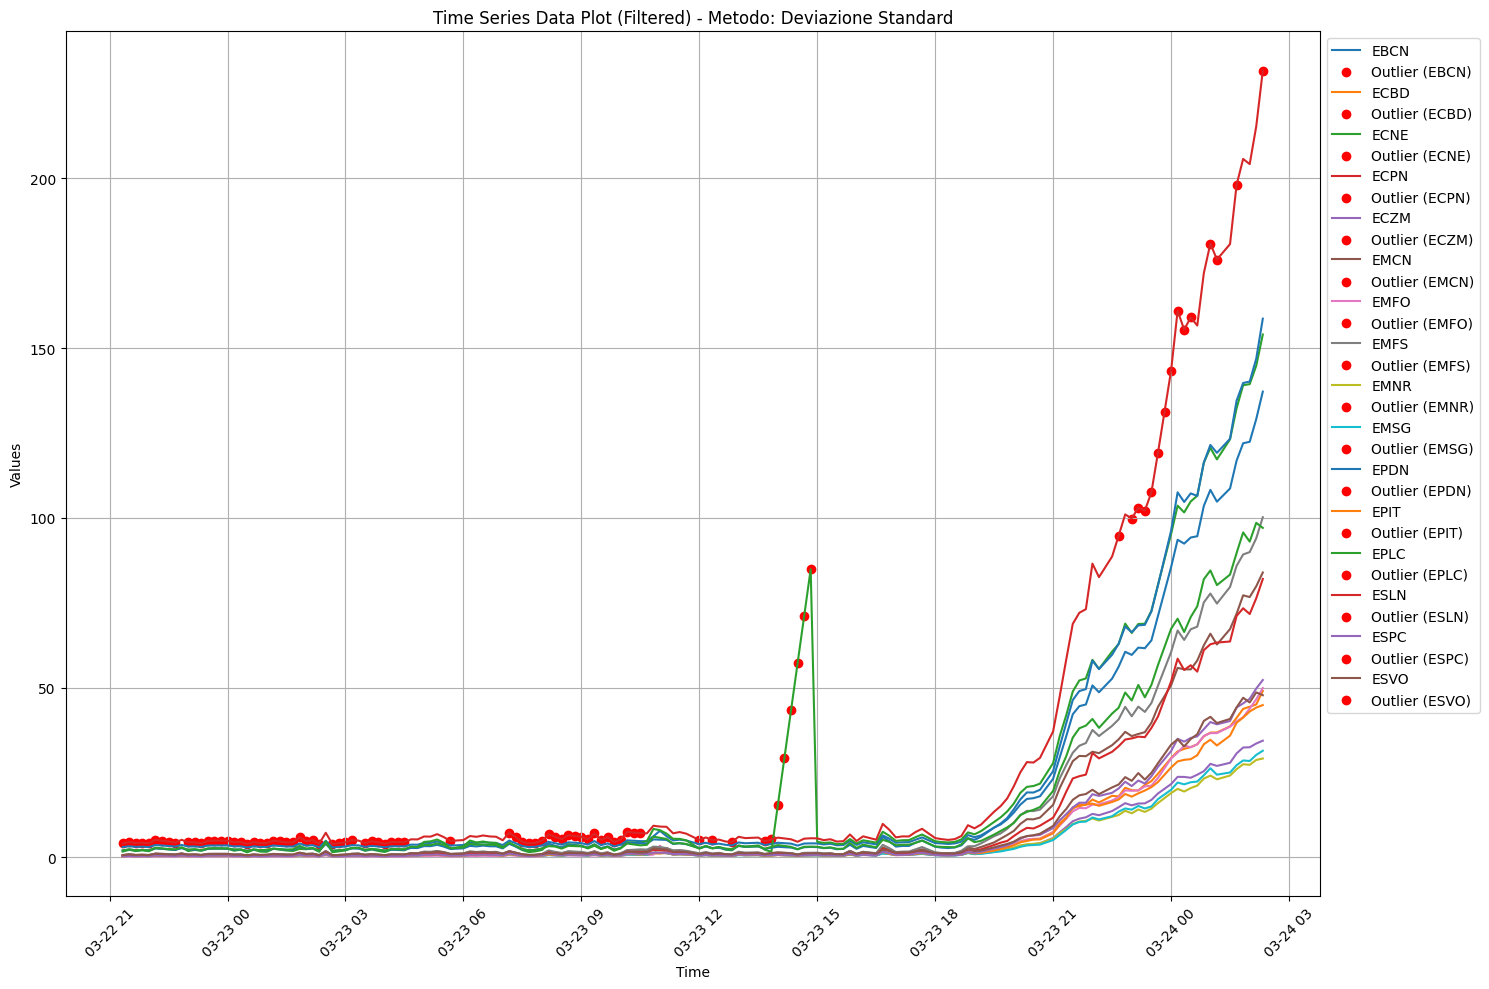

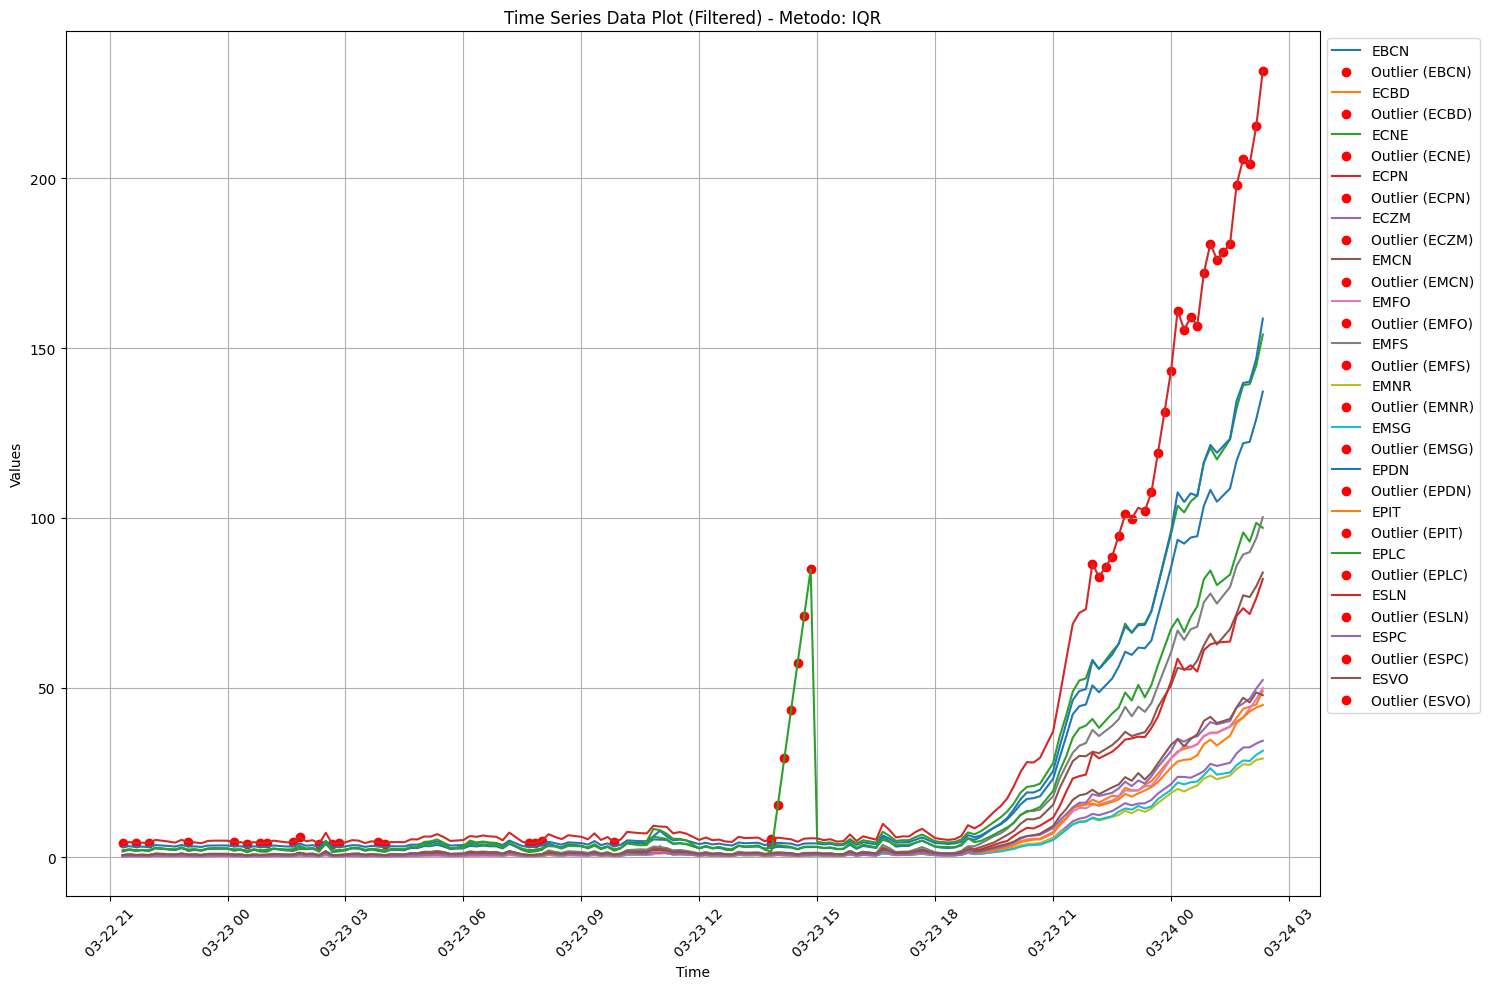

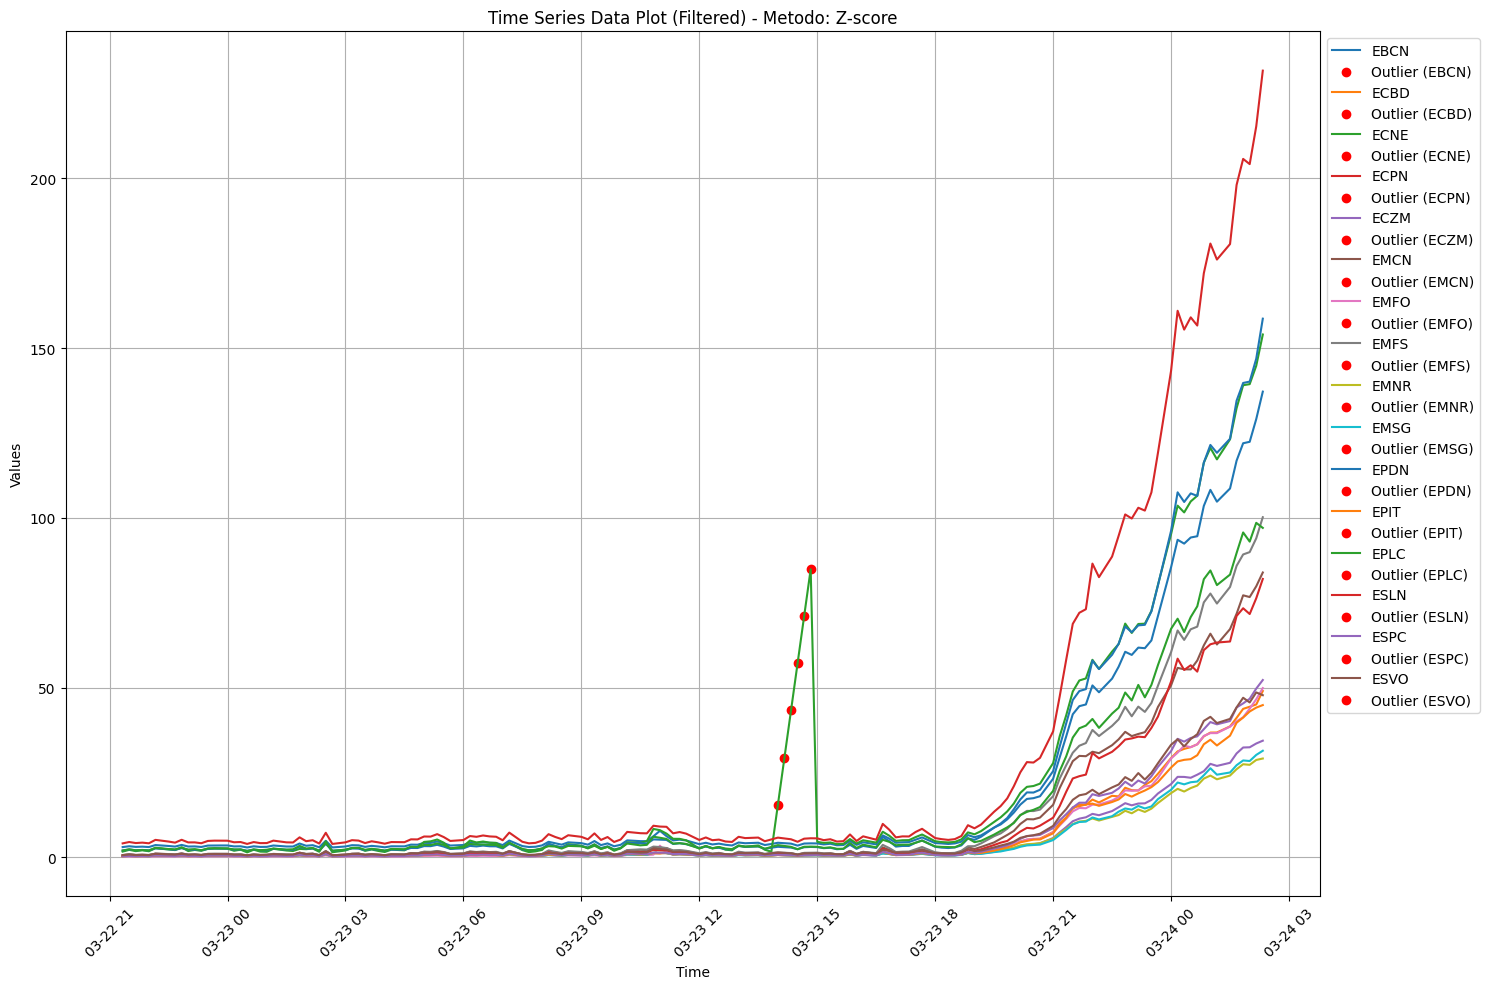

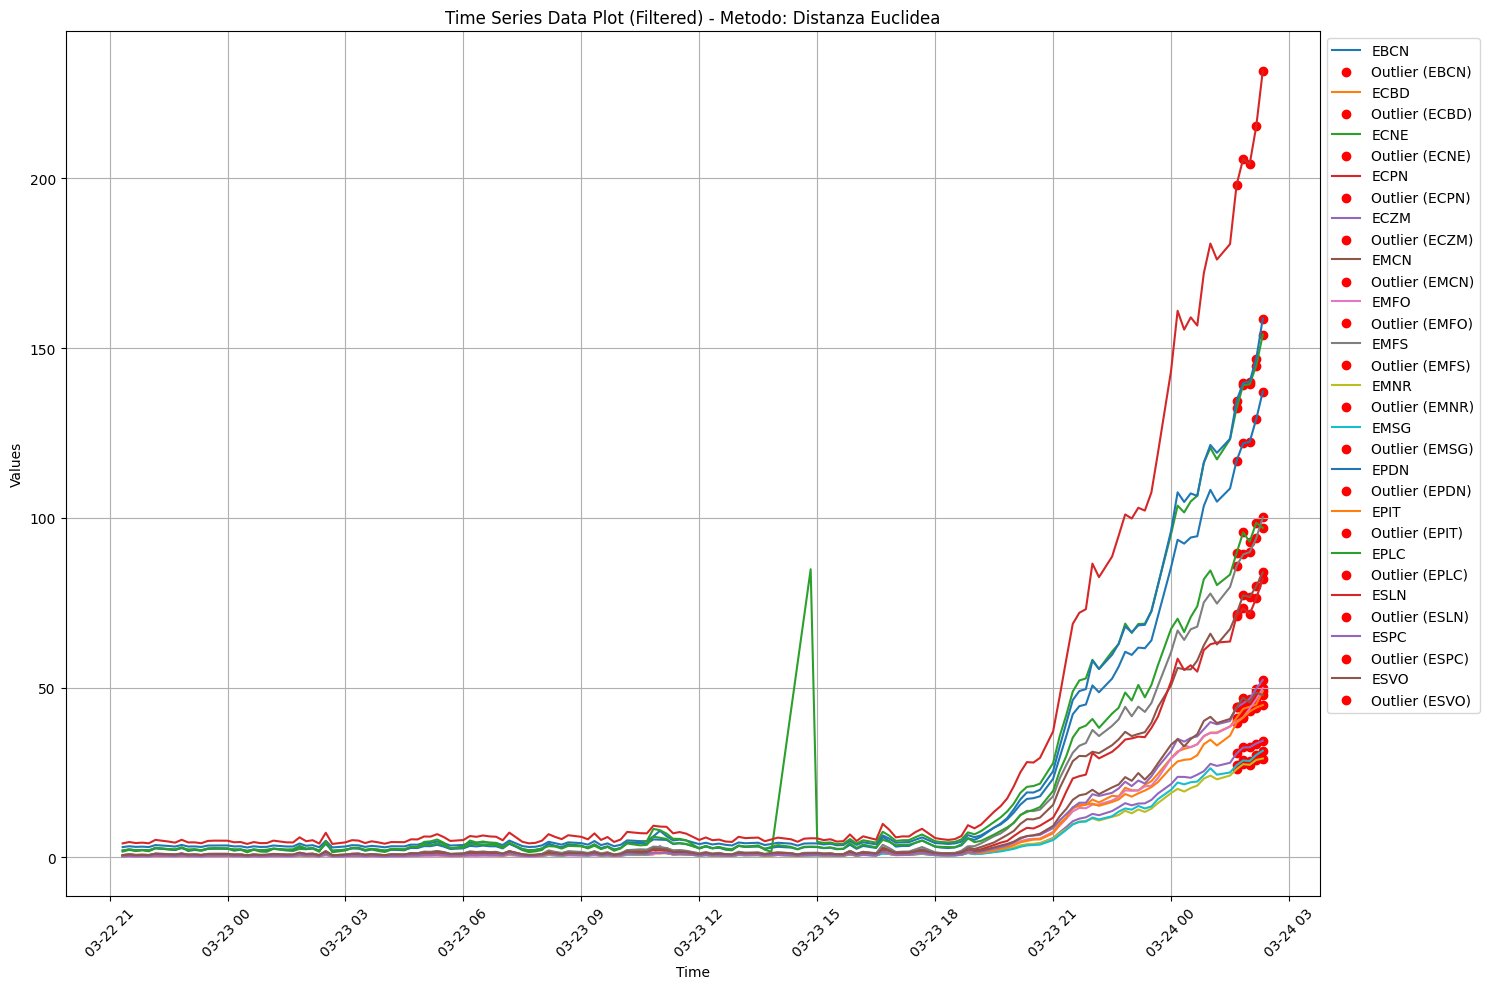

C:\Users\giuli\Desktop\Aquarium\tf_aquarium\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\giuli\Desktop\Aquarium\tf_aquarium\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\giuli\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\giuli\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\giuli\App

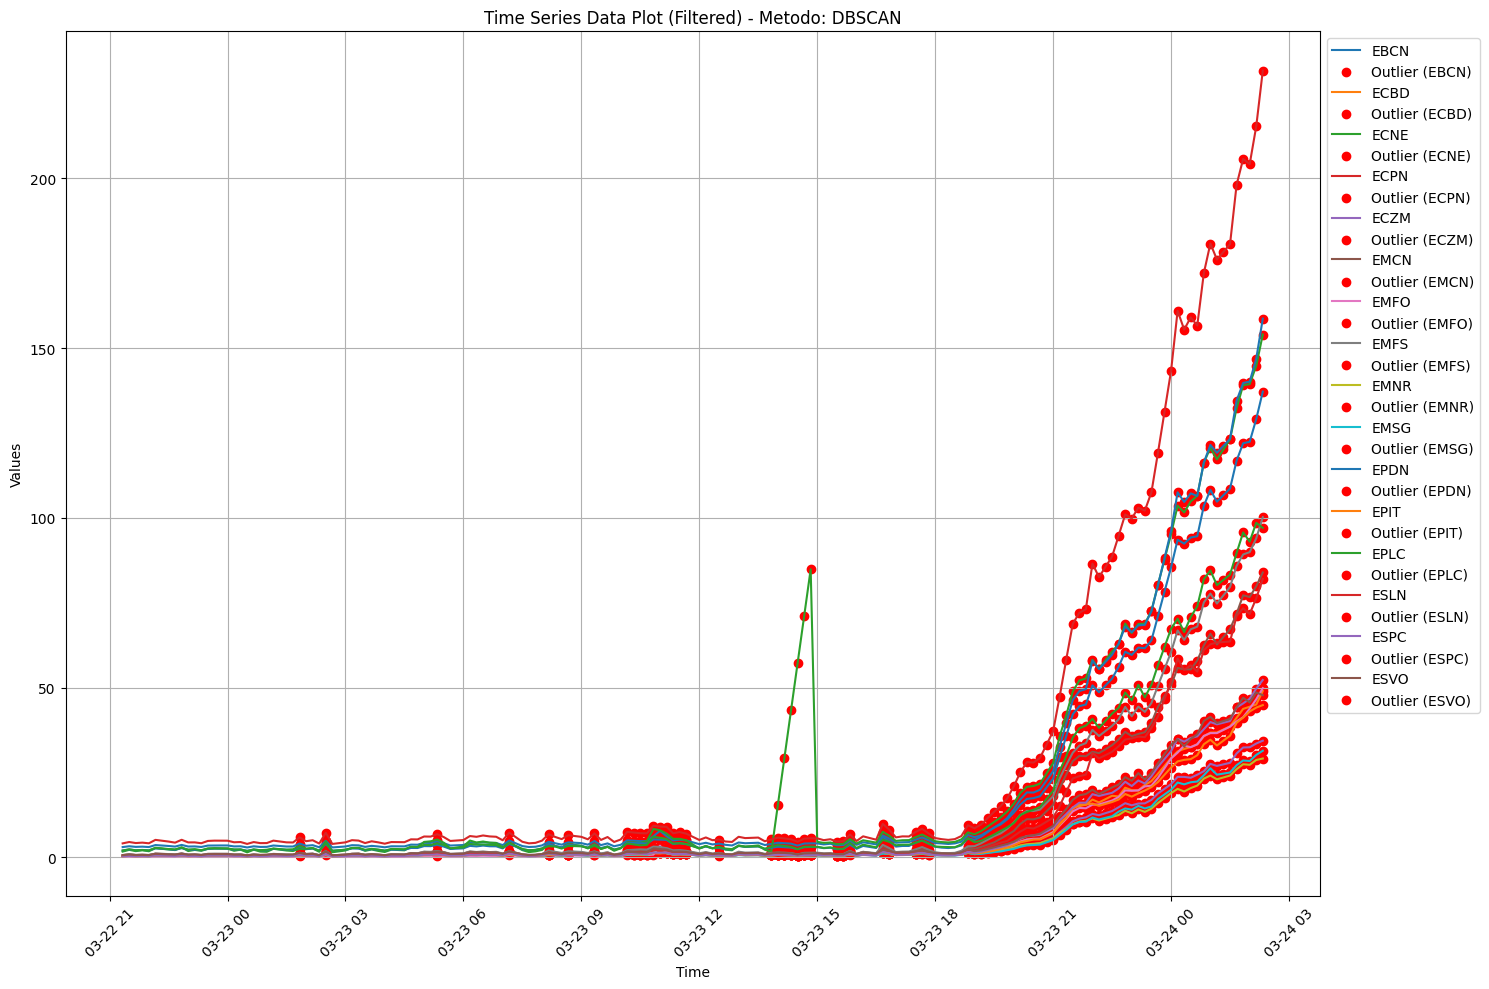

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import cdist

file_path = 'data/IterativeImputer_min0_imputed_dataset.pkl'
df = pd.read_pickle(file_path)

start_time = '2021-3-22 21:20:00'
end_time = '2021-3-24 2:20:00'
df_filtered = df.loc[start_time:end_time]

# Funzioni per trovare gli outlier

# Metodo 1: Deviazione Standard
def find_outliers_std(df, threshold=2.5):
    mean_per_timestep = df.mean(axis=1)
    std_per_timestep = df.std(axis=1)
    upper_bound = mean_per_timestep + threshold * std_per_timestep
    lower_bound = mean_per_timestep - threshold * std_per_timestep
    upper_bound_df = pd.DataFrame(np.tile(upper_bound.values, (df.shape[1], 1)).T, index=df.index, columns=df.columns)
    lower_bound_df = pd.DataFrame(np.tile(lower_bound.values, (df.shape[1], 1)).T, index=df.index, columns=df.columns)
    is_outlier = (df < lower_bound_df) | (df > upper_bound_df)
    return is_outlier

# Metodo 2: IQR
def find_outliers_iqr(df, multiplier=1.5):
    Q1 = df.quantile(0.25, axis=1)
    Q3 = df.quantile(0.75, axis=1)
    IQR = Q3 - Q1
    upper_bound = Q3 + multiplier * IQR
    lower_bound = Q1 - multiplier * IQR
    upper_bound_df = pd.DataFrame(np.tile(upper_bound.values, (df.shape[1], 1)).T, index=df.index, columns=df.columns)
    lower_bound_df = pd.DataFrame(np.tile(lower_bound.values, (df.shape[1], 1)).T, index=df.index, columns=df.columns)
    is_outlier = (df < lower_bound_df) | (df > upper_bound_df)
    return is_outlier

# Metodo 3: Z-score
def find_outliers_zscore(df, threshold=3):
    z_scores = df.apply(zscore, axis=1)
    is_outlier = (z_scores.abs() > threshold)
    return is_outlier

# Metodo 4: Distanza Euclidea
def find_outliers_euclidean(df, threshold=3):
    mean_vector = df.mean(axis=0)  # Media per ogni colonna
    std_vector = df.std(axis=0)    # Deviazione standard per ogni colonna
    
    # Calcolo della distanza euclidea per ogni valore rispetto alla media
    is_outlier = ((df - mean_vector).abs() > threshold * std_vector)
    
    return is_outlier

# Metodo 5: DBSCAN
def find_outliers_dbscan(df, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
    labels = db.labels_
    is_outlier = labels == -1
    is_outlier_df = pd.DataFrame(np.tile(is_outlier, (df.shape[1], 1)).T, index=df.index, columns=df.columns)
    return is_outlier_df

methods = {
    'Deviazione Standard': find_outliers_std,
    'IQR': find_outliers_iqr,
    'Z-score': find_outliers_zscore,
    'Distanza Euclidea': find_outliers_euclidean,
    'DBSCAN': find_outliers_dbscan
}

for method_name, method_function in methods.items():
    is_outlier = method_function(df_filtered)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    for column in df_filtered.columns:
        ax.plot(df_filtered.index, df_filtered[column], label=column)
        ax.scatter(df_filtered.index[is_outlier[column]], df_filtered[column][is_outlier[column]], color='red', label=f'Outlier ({column})')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Time Series Data Plot (Filtered) - Metodo: {method_name}')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
import numpy as np

file_path = 'data/IterativeImputer_min0_imputed_dataset.pkl'
df = pd.read_pickle(file_path)

threshold = 3

mean_per_timestep = df.mean(axis=1)
std_per_timestep = df.std(axis=1)

upper_bound = mean_per_timestep + threshold * std_per_timestep
lower_bound = mean_per_timestep - threshold * std_per_timestep

upper_bound_df = pd.DataFrame(np.tile(upper_bound.values, (df.shape[1], 1)).T, index=df.index, columns=df.columns)
lower_bound_df = pd.DataFrame(np.tile(lower_bound.values, (df.shape[1], 1)).T, index=df.index, columns=df.columns)

is_outlier = (df < lower_bound_df) | (df > upper_bound_df)

df_with_nan = df.mask(is_outlier)

df_interpolated = df_with_nan.interpolate(method='linear', limit_direction='both')

df_interpolated.head()

,EBCN,ECBD,ECNE,ECPN,ECZM,EMCN,EMFO,EMFS,EMNR,EMSG,EPDN,EPIT,EPLC,ESLN,ESPC,ESVO
Time,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,3.494819,0.612916,4.328451,3.277108,0.591486,1.298117,1.151807,1.340139,1.259969,0.667297,2.079882,1.124010,3.046057,0.753591,0.674584,1.301672
2011-01-01 00:10:00,3.332035,0.541441,4.237293,3.179923,0.538378,1.123753,1.025152,1.193932,1.112514,0.612028,2.096310,1.079541,2.925008,0.687502,0.588634,1.159698
2011-01-01 00:20:00,3.474162,0.566139,4.601026,3.455442,0.541607,1.167423,1.066829,1.328691,1.094077,0.579256,2.340912,1.113699,3.024596,0.654296,0.634195,1.139924
2011-01-01 00:30:00,3.251357,0.521349,4.036127,3.073853,0.526033,1.061147,1.042091,1.204915,1.030863,0.551227,1.921758,1.082734,2.619229,0.617176,0.607511,1.077872
2011-01-01 00:40:00,3.827404,0.580080,4.312200,3.310499,0.576615,1.147253,1.616356,1.233082,1.161106,0.614329,2.187143,1.120019,2.939530,0.691127,0.611761,1.154763


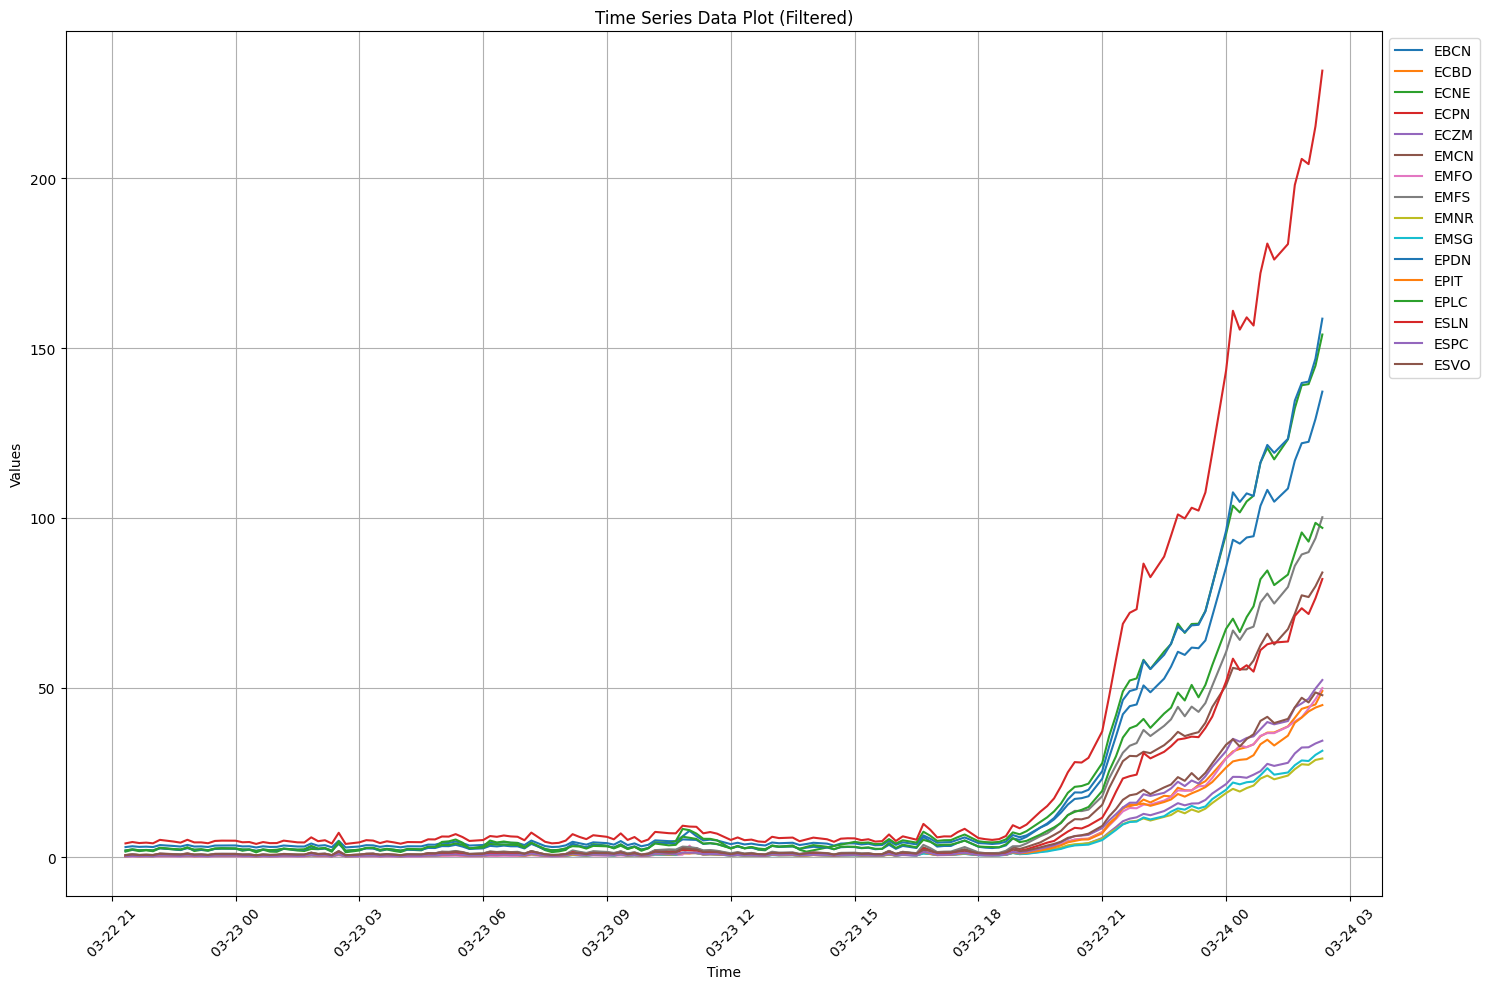

In [7]:
start_time = '2021-3-22 21:20:00'
end_time = '2021-3-24 2:20:00'
# Filtrare il DataFrame
filtered_df = df_interpolated.loc[start_time:end_time]

# Creare nuovamente il grafico
fig, ax = plt.subplots(figsize=(15, 10))

for column in filtered_df.columns:
    ax.plot(filtered_df.index, filtered_df[column], label=column)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data Plot (Filtered)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

In [ ]:
output_file_path = 'data/final_seismic_signals.pkl'
df_interpolated.to_pickle(output_file_path)

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

file_path = 'data/IterativeImputer_min0_imputed_dataset.pkl'
df = pd.read_pickle(file_path)

z_scores = df.apply(zscore, axis=1)

threshold = 3

is_outlier_z = (z_scores > threshold) | (z_scores < -threshold)

df_with_nan_z = df.mask(is_outlier_z)

df_interpolated_z = df_with_nan_z.interpolate(method='linear', limit_direction='both')

output_file_path = 'data/Interpolated_Dataset_ZScore.pkl'
df_interpolated_z.to_pickle(output_file_path)

print(df_interpolated_z.head())


                         EBCN      ECBD      ECNE      ECPN      ECZM  \
Time                                                                    
2011-01-01 00:00:00  3.494819  0.612916  4.328451  3.277108  0.591486   
2011-01-01 00:10:00  3.332035  0.541441  4.237293  3.179923  0.538378   
2011-01-01 00:20:00  3.474162  0.566139  4.601026  3.455442  0.541607   
2011-01-01 00:30:00  3.251357  0.521349  4.036127  3.073853  0.526033   
2011-01-01 00:40:00  3.827404  0.580080  4.312200  3.310499  0.576615   

                         EMCN      EMFO      EMFS      EMNR      EMSG  \
Time                                                                    
2011-01-01 00:00:00  1.298117  1.151807  1.340139  1.259969  0.667297   
2011-01-01 00:10:00  1.123753  1.025152  1.193932  1.112514  0.612028   
2011-01-01 00:20:00  1.167423  1.066829  1.328691  1.094077  0.579256   
2011-01-01 00:30:00  1.061147  1.042091  1.204915  1.030863  0.551227   
2011-01-01 00:40:00  1.147253  1.616356  1.233082 

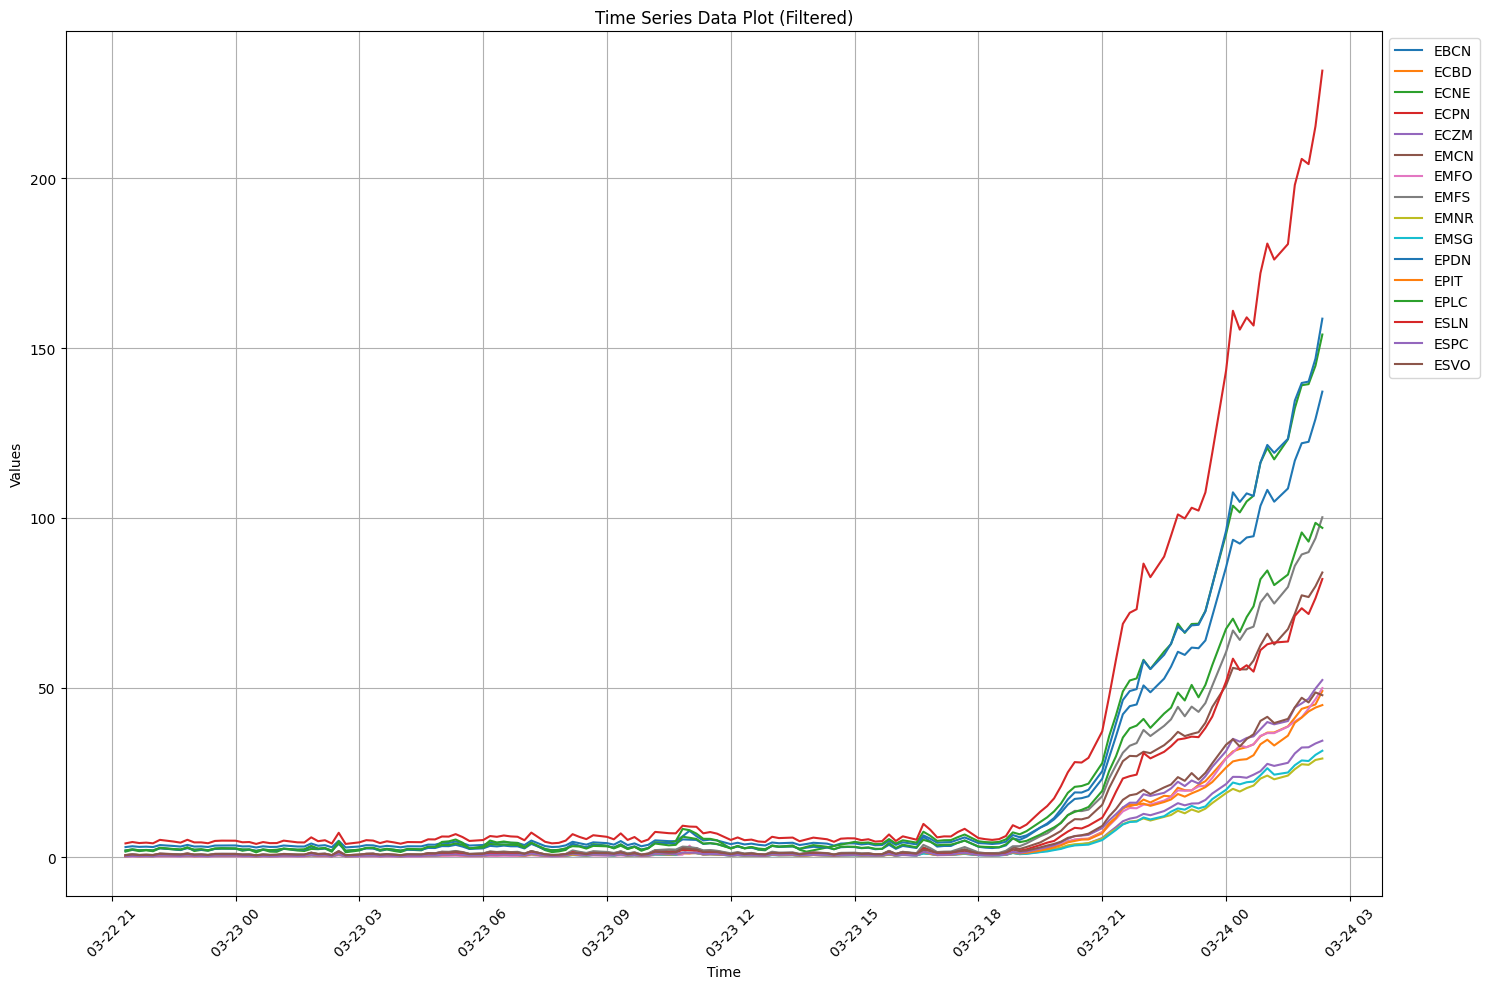

In [9]:
start_time = '2021-3-22 21:20:00'
end_time = '2021-3-24 2:20:00'
# Filtrare il DataFrame
filtered_df = df_interpolated_z.loc[start_time:end_time]

# Creare nuovamente il grafico
fig, ax = plt.subplots(figsize=(15, 10))

for column in filtered_df.columns:
    ax.plot(filtered_df.index, filtered_df[column], label=column)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data Plot (Filtered)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()